In [1]:
%run './model/multi_corpus.py'
%run './constants.py'

sns.set(rc = {'figure.figsize':(15,8)})

In [2]:
corpora = co_occurence_graphs(n_edges=100)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 58 nodes and 100 edges
Geometry Graph with 70 nodes and 100 edges
Geophysics Graph with 65 nodes and 100 edges
Economics Graph with 48 nodes and 100 edges
Language & Linguistics Graph with 57 nodes and 100 edges
Probability & Statistics Graph with 60 nodes and 100 edges
Material Engineering Graph with 48 nodes and 100 edges
Artificial Intelligence Graph with 50 nodes and 100 edges
Sociology Graph with 75 nodes and 100 edges
International Business Graph with 55 nodes and 100 edges
Political Science Graph with 56 nodes and 100 edges
Genetics & Genomics Graph with 72 nodes and 100 edges
Immunology Graph with 89 nodes and 100 edges
Human Resources & Organizations Graph with 67 nodes and 100 edges
Ethnic & Cultural Studies Graph with 54 nodes and 100 edges
Neurology Graph with 47 nodes and 100 edges


# Co-Occurence Graph

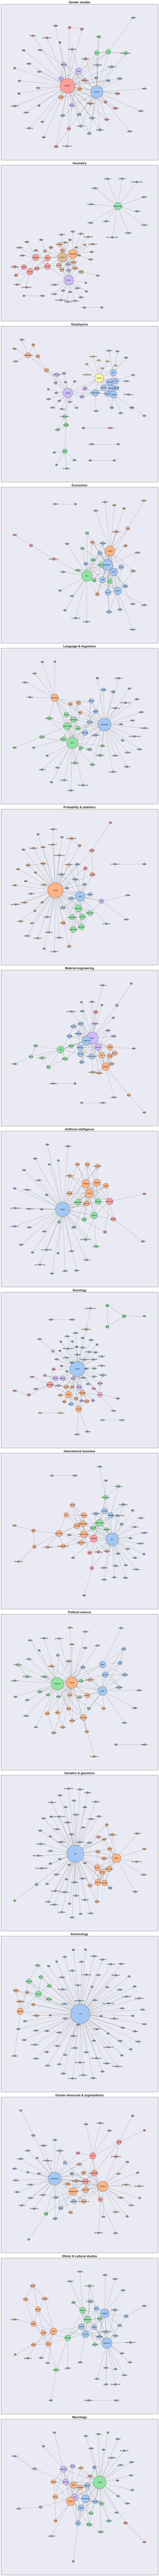

In [4]:
sns.set()
communities=True
co_citation=False

sns.set()
n_cols = 1
height = 15
width = 15
n_rows = np.ceil(len(Gs) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*height, n_rows*width))
for ax, (field_name, G) in zip(axs, Gs.items()):

    node_deg = dict(nx.degree(G))
    node_names = list(node_deg.keys())
    node_sizes = list(map(lambda deg: deg*200, node_deg.values()))
    node_labels = dict(zip(node_names, node_names))

    new_node_labels = (
        pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
        .select(
            pl.col('Doi'), 
            pl.concat_str([
                pl.lit('('),
                pl.col('Authors').arr.first().str.split(', ').arr.first(),
                pl.lit(', '),
                pl.col('Date').dt.year(),
                pl.lit(')')
            ])
        )
        .filter(pl.col('Doi').is_in(node_names))
        .to_numpy()
    )

    new_node_labels = dict(map(tuple, new_node_labels))
    if co_citation:
        node_labels.update(new_node_labels)

    if communities:
        comms = nx_comm.louvain_communities(G)
        palette = sns.color_palette("pastel", len(comms))
        node_color_map = {}
        for comm, color in zip(comms, palette):
            for node in comm:
                node_color_map[node] = color
        node_color = [node_color_map[n] for n in G.nodes]
        node_color

    pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # dot, twopi, fdp, sfdp, circo

    nx.draw_networkx_nodes(
        G, 
        pos,
        nodelist=node_names,
        node_size=node_sizes,
        # node_color='#00ABB3',
        node_color=node_color,
        node_shape='o',
        alpha=None,
        cmap=plt.cm.Blues,
        ax=ax,
        linewidths=1.0,
        edgecolors='k',
    ).set_zorder(1)

    nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=node_labels)

    nx.draw_networkx_edges(
        G, 
        pos,
        width=1.0,
        edge_color='k',
        style='solid',
        alpha=0.5,
        arrowsize=10,
        ax=ax,
        nodelist=node_names,
        node_size=node_sizes,
        node_shape='o',
        connectionstyle='arc3',
    ).set_zorder(-1)


    ax.set_title(f'{field_name.capitalize()}', fontweight='semibold', fontsize=20)
    
    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)
    
    ax.grid(False)

plt.tight_layout()
plt.savefig(f'{OBSIDIAN_IMG_PATH}/co_occurence_networks.png')
plt.show()



# Descriptive

In [18]:
d = {}

for field_name, corpus in corpora.items():

    df = corpus['Df']
    G = corpus['G']
    nodes = list(G.nodes)

    large_component = max(nx.connected_components(G), key=len)
    G_large_component = G.subgraph(large_component)

    # NODES EDGES
    number_of_nodes = nx.number_of_nodes(G)
    number_of_edges = nx.number_of_edges(G)

    # DENSITY
    density = nx.density(G)

    # TRIANGLES
    triangles = sum(nx.triangles(G).values()) / 3

    # DEGREE
    degree = dict(G.degree()).values()
    avg_degree = sum(degree) / len(degree)

    # GINI
    degrees = G.degree()
    gini = 1 - sum((degrees[n] / len(G.edges))**2 for n in G.nodes)

    # COMPONENTS
    n_connected_components = len(list(nx.connected_components(G)))

    # DIAMETER
    
    diameter = nx.diameter(G.subgraph(large_component))
    
    # SHORTEST PATH
    shortest_path = nx.shortest_path_length(G)

    # AVG SHORTEST PATH
    average_shortest_path_length = nx.average_shortest_path_length(G_large_component)

    # CLUSTERING
    clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)

    # DATES
    start_date, end_date = (
        df
        .filter(pl.col('Doi').is_in(nodes))
        .select(
            pl.col('Date').min().alias('Min'),
            pl.col('Date').max().alias('Max'),
        )
        .row(0)
    )

    # CENTRALIZATION
    degrees = dict(G.degree()).values()
    centralization = float((len(G) * max(degrees) - sum(degrees))) / (len(G)-1)**2

    # COMMUNITIES
    louvain_communities = len(nx_comm.louvain_communities(G))
    label_propagation_communities = len(nx_comm.label_propagation_communities(G))

    # ISOLATES LOOPS CYCLES
    isolates = nx.number_of_isolates(G)
    loops = nx.number_of_selfloops(G)

    d[field_name] = {
        'Nodes': number_of_nodes,
        'Edges': number_of_edges,
        'Density': round(density, 4),
        'DiameterLargestComponent': diameter,
        'AvgShortestPath': average_shortest_path_length,
        'Triangles': triangles,
        'AvgDegree': round(avg_degree, 4),
        'Gini': round(gini, 4),
        'LouvainCommunities': louvain_communities,
        'LabelPropagationCommunities': label_propagation_communities,
        'ConnectedComponent': n_connected_components,
        'Clustering': round(clustering, 4),
        'Transitivity': round(transitivity, 4),
        'Centralization': round(centralization, 4),
        'Isolates': isolates,
        'Loops': loops,
    }

ds = [{'Field': field_name} | desc_d for field_name, desc_d in d.items()]
df = pl.DataFrame(ds)

df.write_csv(os.path.join(OBSIDIAN_TABLE_PATH, 'co_occurence_descriptive_statistics.csv'))
for c in df.columns:
    print(f'{c},')
df

Field,
Nodes,
Edges,
Density,
DiameterLargestComponent,
AvgShortestPath,
Triangles,
AvgDegree,
Gini,
LouvainCommunities,
LabelPropagationCommunities,
ConnectedComponent,
Clustering,
Transitivity,
Centralization,
Isolates,
Loops,


shape: (16, 17)
┌────────────────┬───────┬───────┬─────────┬─────┬──────────────┬───────────────┬──────────┬───────┐
│ Field          ┆ Nodes ┆ Edges ┆ Density ┆ ... ┆ Transitivity ┆ Centralizatio ┆ Isolates ┆ Loops │
│ ---            ┆ ---   ┆ ---   ┆ ---     ┆     ┆ ---          ┆ n             ┆ ---      ┆ ---   │
│ str            ┆ i64   ┆ i64   ┆ f64     ┆     ┆ f64          ┆ ---           ┆ i64      ┆ i64   │
│                ┆       ┆       ┆         ┆     ┆              ┆ f64           ┆          ┆       │
╞════════════════╪═══════╪═══════╪═════════╪═════╪══════════════╪═══════════════╪══════════╪═══════╡
│ Gender Studies ┆ 58    ┆ 100   ┆ 0.0605  ┆ ... ┆ 0.09         ┆ 0.8132        ┆ 0        ┆ 0     │
│ Geometry       ┆ 70    ┆ 100   ┆ 0.0414  ┆ ... ┆ 0.1711       ┆ 0.2668        ┆ 0        ┆ 0     │
│ Geophysics     ┆ 65    ┆ 100   ┆ 0.0481  ┆ ... ┆ 0.3156       ┆ 0.2686        ┆ 0        ┆ 0     │
│ Economics      ┆ 48    ┆ 100   ┆ 0.0887  ┆ ... ┆ 0.2641       ┆ 0.4744        ┆ 0        ┆ 0     │
│ ...            ┆ ...   ┆ ...   ┆ ...     ┆ ... ┆ ...          ┆ ...           ┆ ...      ┆ ...   │
│ Immunology     ┆ 86    ┆ 100   ┆ 0.0274  ┆ ... ┆ 0.016        ┆ 0.9722        ┆ 0        ┆ 0     │
│ Human          ┆ 62    ┆ 100   ┆ 0.0529  ┆ ... ┆ 0.1395       ┆ 0.5794        ┆ 0        ┆ 0     │
│ Resources &    ┆       ┆       ┆         ┆     ┆              ┆               ┆          ┆       │
│ Organizations  ┆       ┆       ┆         ┆     ┆              ┆               ┆          ┆       │
│ Ethnic &       ┆ 55    ┆ 100   ┆ 0.0673  ┆ ... ┆ 0.2296       ┆ 0.3841        ┆ 0        ┆ 0     │
│ Cultural       ┆       ┆       ┆         ┆     ┆              ┆               ┆          ┆       │
│ Studies        ┆       ┆       ┆         ┆     ┆              ┆               ┆          ┆       │
│ Neurology      ┆ 50    ┆ 100   ┆ 0.0816  ┆ ... ┆ 0.2361       ┆ 0.6872        ┆ 0        ┆ 0     │
└────────────────┴───────┴───────┴─────────┴─────┴──────────────┴───────────────┴──────────┴───────┘

# Edge Distribution

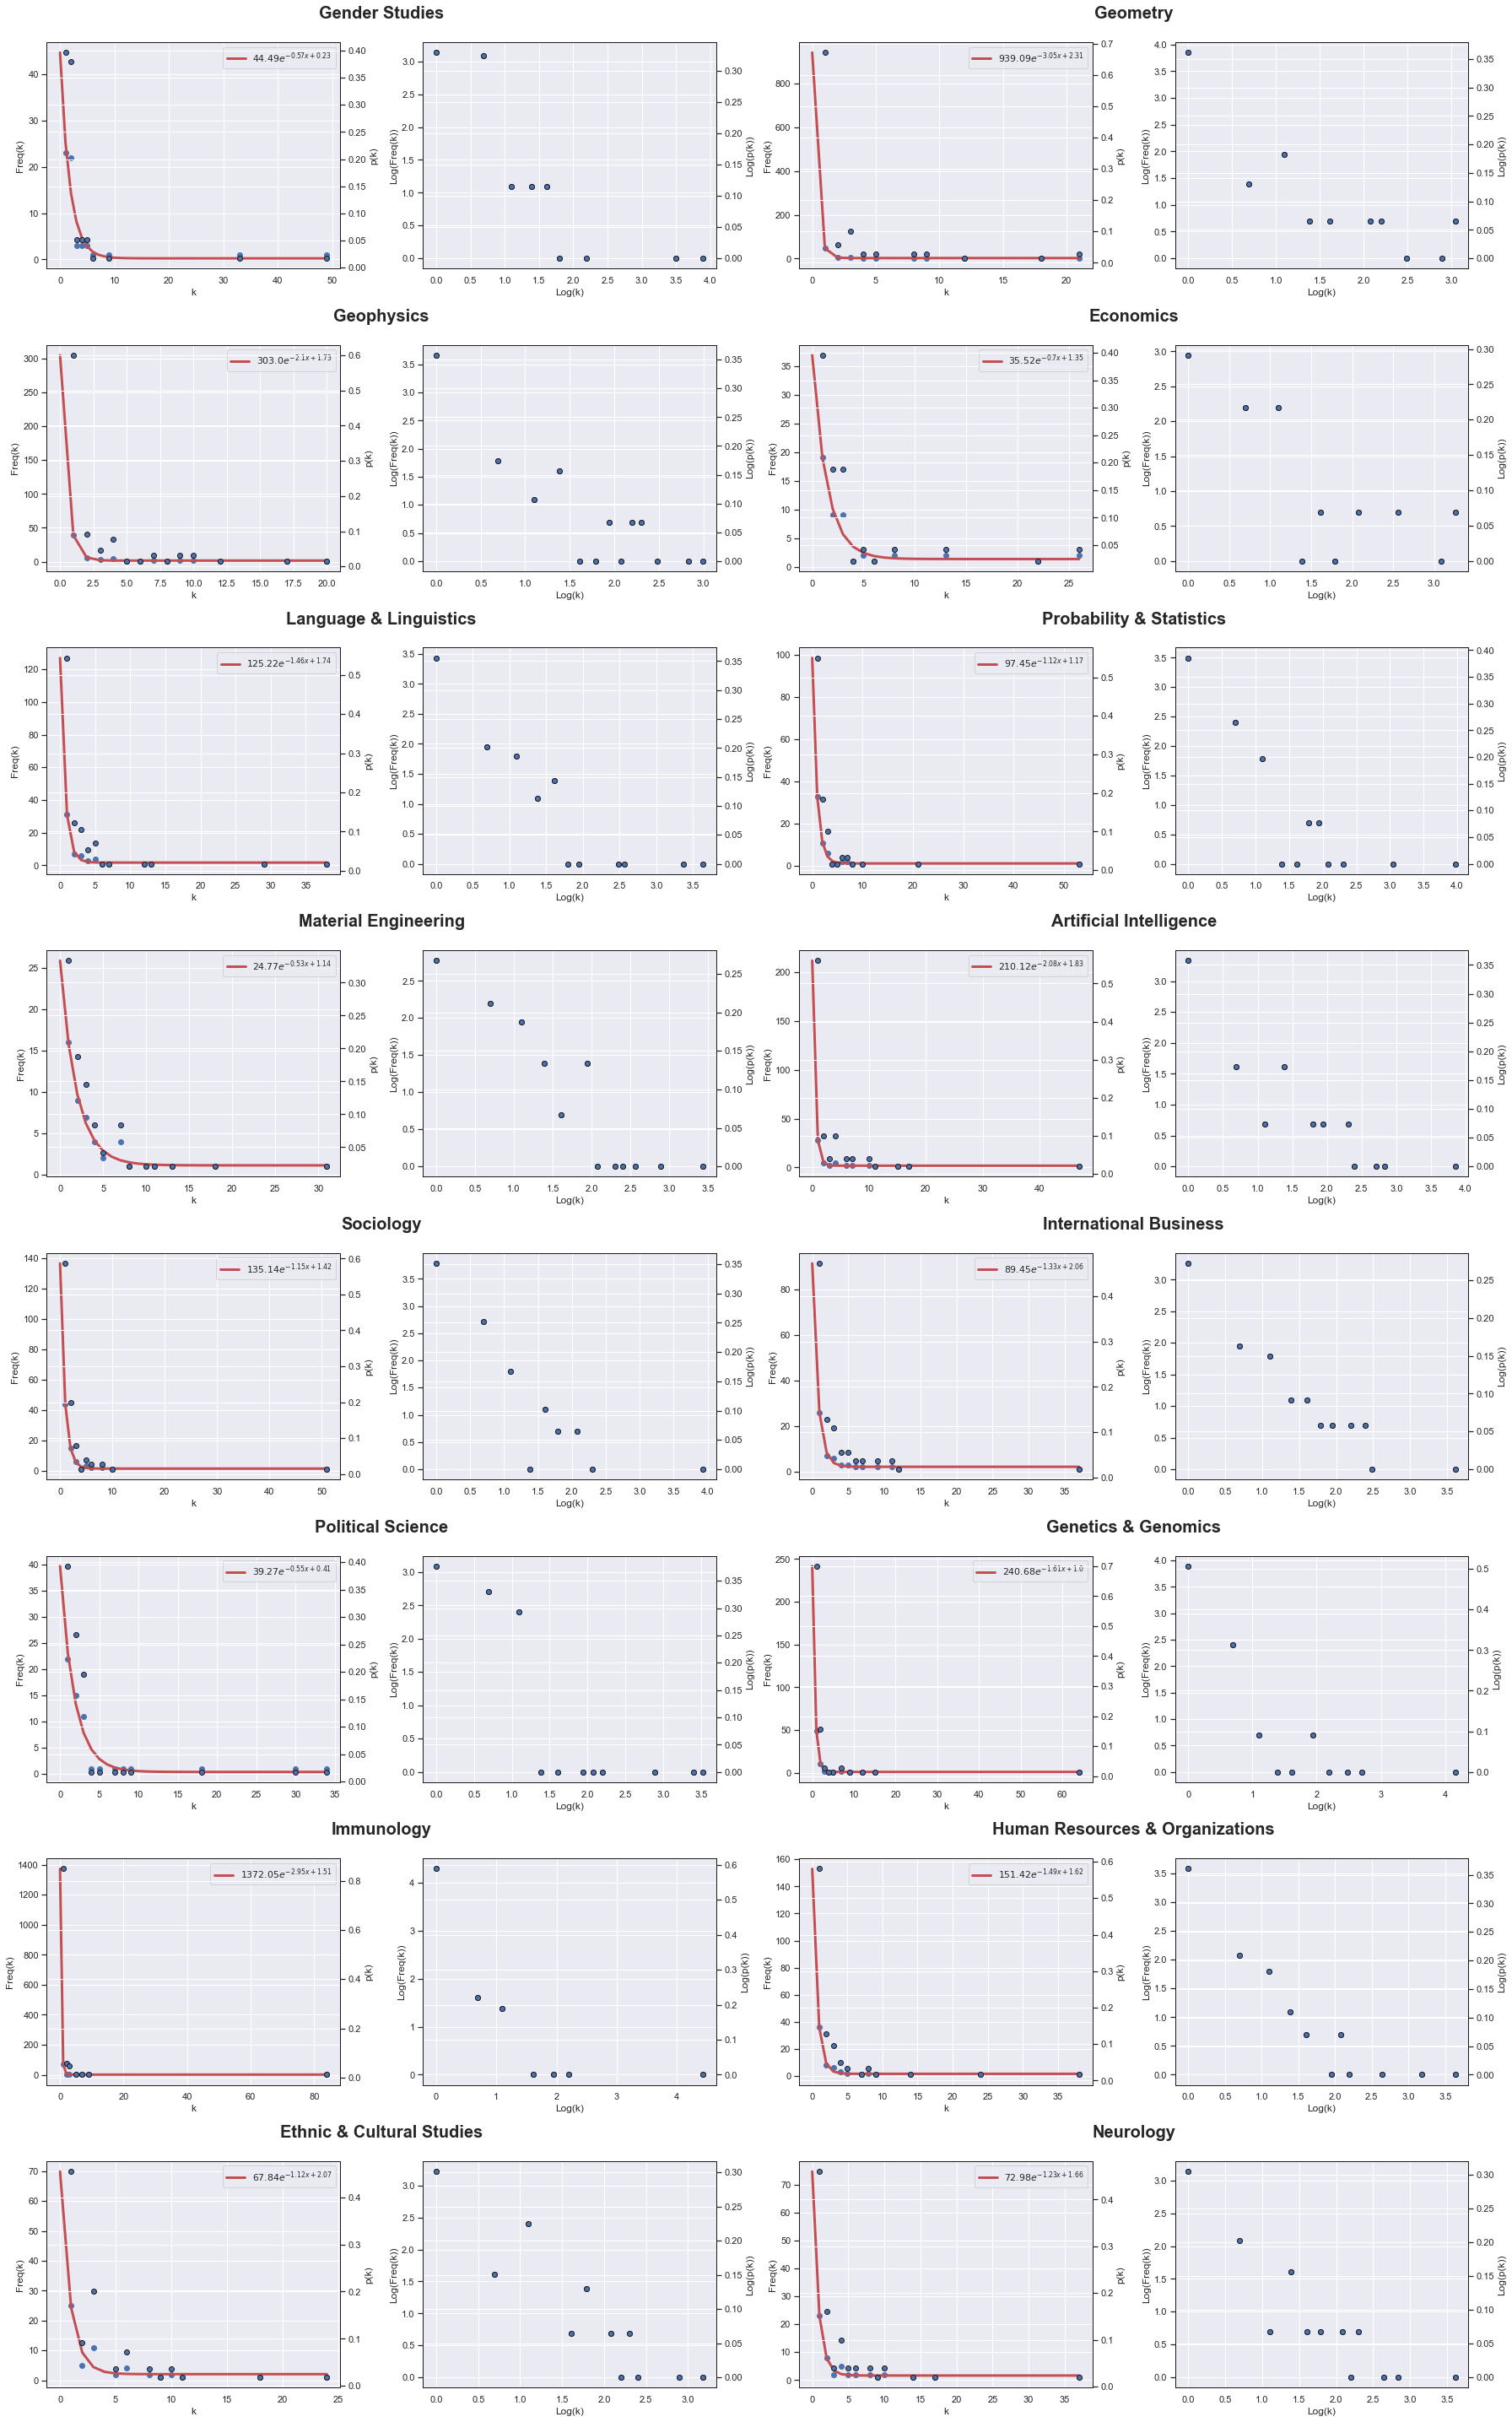

In [5]:
data = []
field_names = []

for i, (field_name, corpus) in enumerate(corpora.items()):

    G = corpus['G']

    if G.is_directed():
        node_degrees = dict(G.in_degree())
    else:
        node_degrees = dict(G.degree())
    degrees = node_degrees.values()

    k, freq = zip(*Counter(degrees).items())
    p_k = np.array(freq) / np.sum(freq)

    log_k, log_freq = np.log(k), np.log(freq)
    log_p_k = np.array(log_freq) / np.sum(log_freq)

    data.append((k, freq, p_k))
    data.append((log_k, log_freq, log_p_k))
    field_names.append(field_name)

data = [data[i:i+4] for i in range(0, len(data), 4)]
field_names = [field_names[i:i+2] for i in range(0, len(field_names), 2)]

n_fields = len([f for field in field_names for f in field])
n_cols = 4
n_rows = int((n_fields+1 if n_fields%2 != 0 else n_fields) / 2)

fig = plt.figure(figsize=(25, n_rows*5))
gs = gridspec.GridSpec(n_rows, n_cols)

for i in range(n_rows):

    row = fig.add_subplot(gs[i, 0:2])
    row.set_frame_on(False)
    row.axis('off')
    try:
        row.set_title(f'{field_names[i][0]}\n', fontweight='semibold', fontsize=20)
    except IndexError:
        pass
    
    row = fig.add_subplot(gs[i, 2:5])
    row.set_frame_on(False)
    row.axis('off')
    try:
        row.set_title(f'{field_names[i][1]}\n', fontweight='semibold', fontsize=20)
    except IndexError:
        pass

    for j in range(n_cols):
        try:
            x, y, p_x = data[i][j]
            ax = fig.add_subplot(gs[i, j])
        except IndexError:
            continue
        
        ax.plot(x, y, 'o')

        axs0 = ax.twinx()
        axs0.plot(x, p_x, 'o', markeredgewidth=1, markeredgecolor='k')

        if j%2 == 0:

            p0 = (1, 0, 0)
            def exponenial_func(x, a, b, c):
                return a*np.exp(-b*x)+c
            popt, pcov = curve_fit(exponenial_func, x, y, p0=p0)
            x_fit = np.arange(0, max(x)+1, 1)
            y_fit = exponenial_func(x_fit, *popt)

            a, b, c = popt.round(2)
            ax.plot(x_fit, y_fit, 'r-', linewidth=3, label=f'${a}e^{{-{b}x + {c}}}$')

            ax.set_xlabel('k')
            ax.set_ylabel('Freq(k)')

            axs0.set_ylabel('p(k)')

            ax.legend()
        else:
            ax.set_xlabel('Log(k)')
            ax.set_ylabel('Log(Freq(k))')

            axs0.set_ylabel('Log(p(k))')

        ax.spines['top'].set_color('k')
        ax.spines['top'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['right'].set_color('k')
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['left'].set_linewidth(1)
        
        axs0.spines['top'].set_color('k')
        axs0.spines['top'].set_linewidth(1)
        axs0.spines['bottom'].set_color('k')
        axs0.spines['bottom'].set_linewidth(1)
        axs0.spines['right'].set_color('k')
        axs0.spines['right'].set_linewidth(1)
        axs0.spines['left'].set_color('k')
        axs0.spines['left'].set_linewidth(1)

plt.tight_layout()

# plt.savefig(f'{OBSIDIAN_IMG_PATH}/co_occurence_degree_distribution.png')
plt.show()

# HeatMap

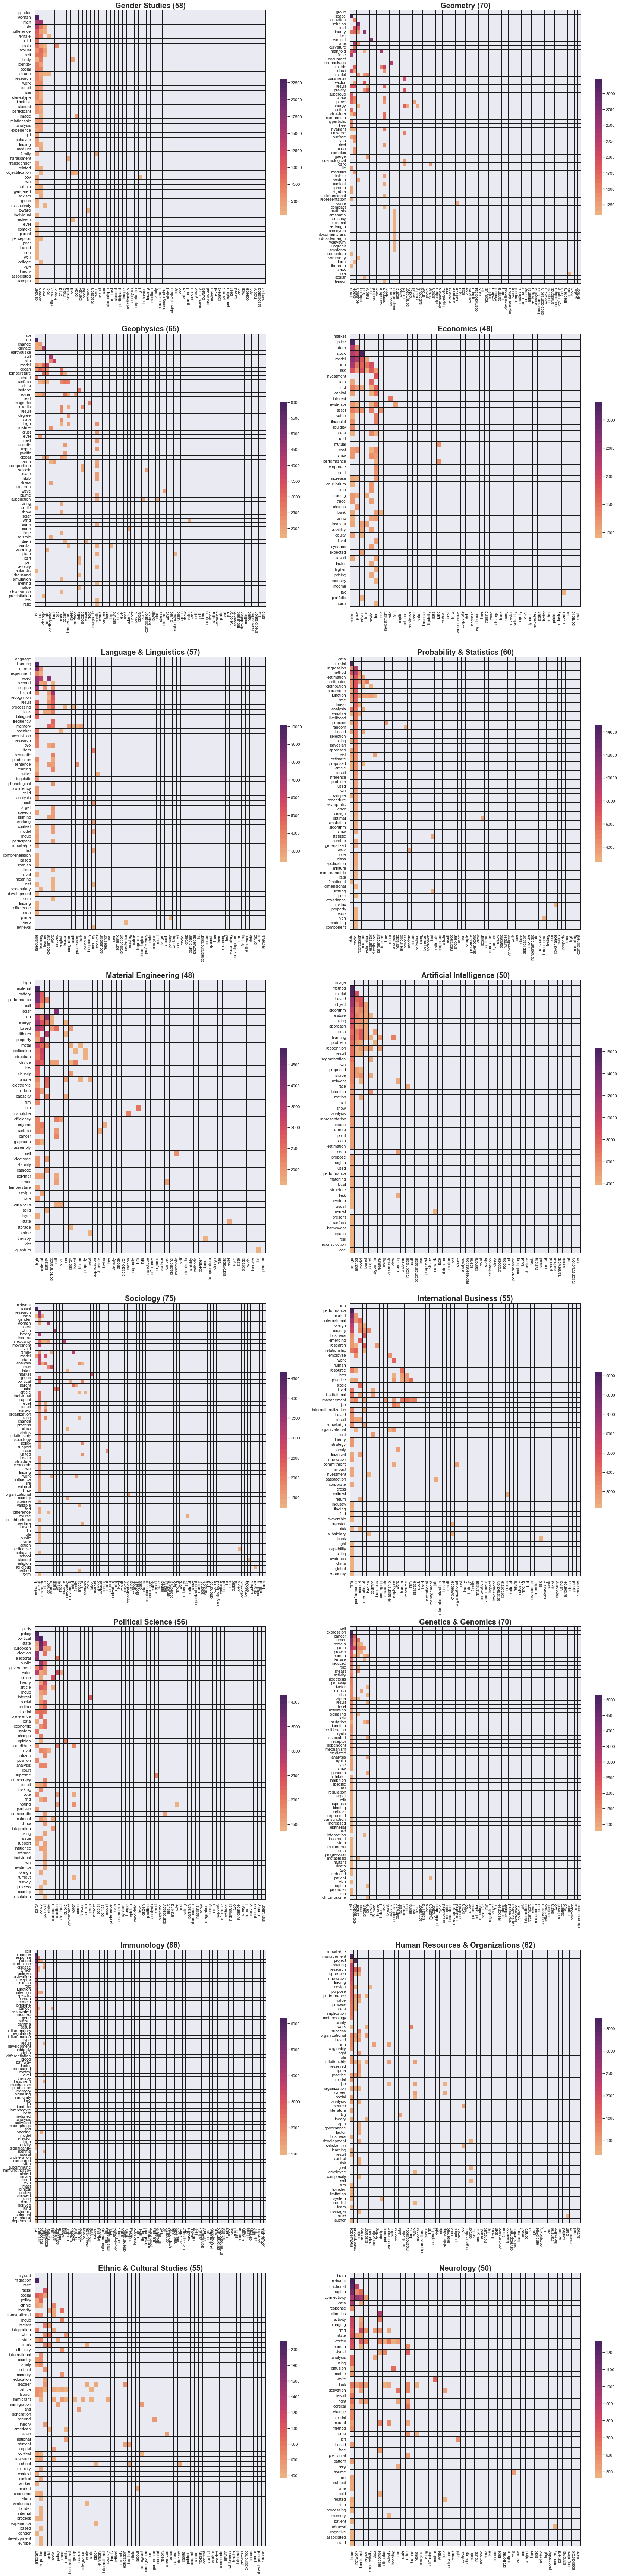

In [7]:
n_cols = 2
height = 12
width = 12
n_rows = np.ceil(len(Gs) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*height, n_rows*width))
for (field_name, G), ax in zip(Gs.items(), axs.flatten()):

    nodes = G.nodes
    am = nx.to_numpy_array(G)
    up_triang = np.triu(np.ones_like(am)).astype(bool)
    cmap = plt.get_cmap('flare',30)
    cmap.set_under('white')
    cmap.set_over('yellow')

    sns.heatmap(am, linewidth=.5, cmap=cmap, linecolor='k', linewidths=0.5, xticklabels=nodes, yticklabels=nodes, mask=(am==0) | (up_triang), ax=ax, cbar_kws={"shrink": 0.5})

    ax.set_title(f'{field_name} ({len(nodes)})', fontweight='semibold', fontsize=20)

    ax.set_xlim(0, len(G) + 0.1)
    ax.set_ylim(len(G) + 0.1, 0)
plt.tight_layout()
# plt.savefig(os.path.join(OBSIDIAN_IMG_PATH, 'co_occurence_heatmap.png'))
plt.show()


# Dendrogram

## Girvan-Newmann

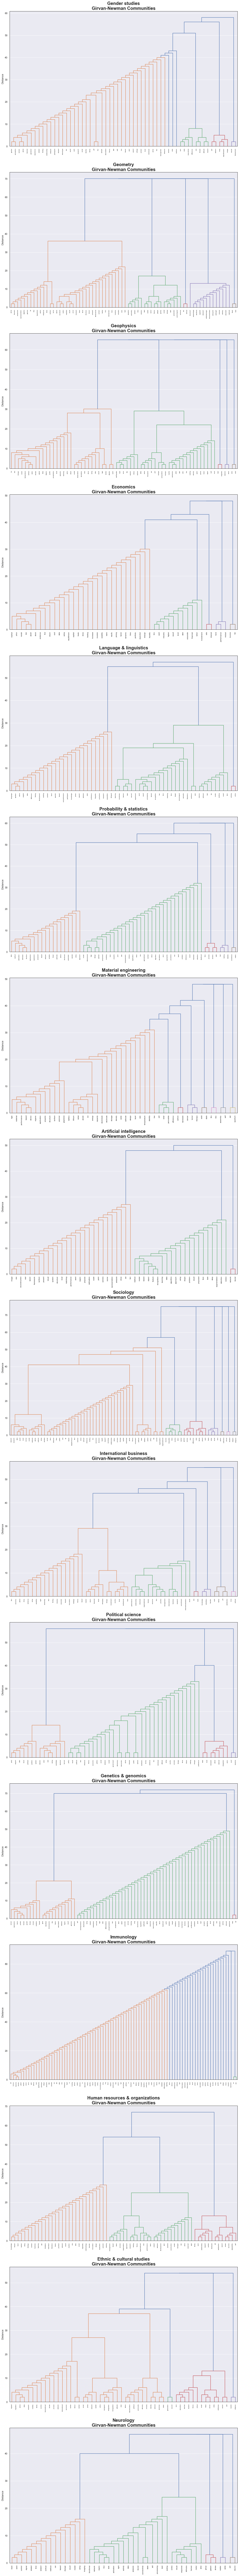

In [6]:

sns.set()
n_cols = 1
width = 10
height = 15
n_rows = np.ceil(len(Gs) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*height, n_rows*width))
for ax, (field_name, G) in zip(axs, Gs.items()):

    nodes = list(G.nodes)
    comms = list(nx_comm.girvan_newman(G))
    comms.insert(0, (set(nodes),))

    Z, leaves = compute_Z(comms)

    # ax.set_xlabel('Node')
    ax.set_ylabel('Distance')
    
    dendrogram(Z, labels=leaves, ax=ax)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    fig.set_facecolor('w')

    ax.set_title(f'{field_name.capitalize()}\nGirvan-Newman Communities', fontweight='semibold', fontsize=20)

    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

plt.tight_layout()
plt.savefig(f'{OBSIDIAN_IMG_PATH}/co_occurence_girvan_dendrogram.png')
plt.show()


## Louvain

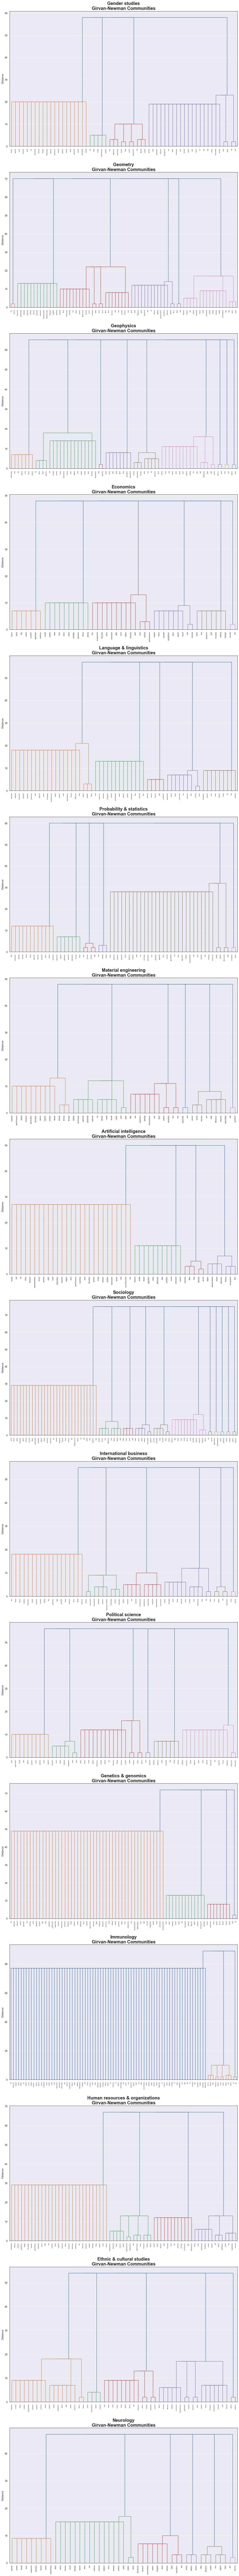

In [7]:

sns.set()
n_cols = 1
width = 10
height = 15
n_rows = np.ceil(len(Gs) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*height, n_rows*width))
for ax, (field_name, G) in zip(axs, Gs.items()):

    nodes = list(G.nodes)
    
    comms = list(sorted(nx_comm.louvain_partitions(G, weight=None), key=len))
    comms.insert(0, (set(nodes),))
    comms.append(tuple({n} for n in nodes))

    Z, leaves = compute_Z(comms)

    # ax.set_xlabel('Node')
    ax.set_ylabel('Distance')
    
    dendrogram(Z, labels=leaves, ax=ax)
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    fig.set_facecolor('w')

    ax.set_title(f'{field_name.capitalize()}\nGirvan-Newman Communities', fontweight='semibold', fontsize=20)

    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

plt.tight_layout()
plt.savefig(f'{OBSIDIAN_IMG_PATH}/co_occurence_louvain_dendrogram.png')
plt.show()


# Clusters

In [6]:
communities = {}
for field_name, G in Gs.items():
    communities[field_name] = nx_comm.louvain_communities(G)

In [7]:
{field_name: len(comms) for field_name, comms in communities.items()}

{'Gender Studies': 4,
 'Geometry': 7,
 'Geophysics': 9,
 'Economics': 6,
 'Language & Linguistics': 3,
 'Probability & Statistics': 6,
 'Material Engineering': 7,
 'Artificial Intelligence': 4,
 'Sociology': 11,
 'International Business': 6,
 'Political Science': 4,
 'Genetics & Genomics': 3,
 'Immunology': 3,
 'Human Resources & Organizations': 4,
 'Ethnic & Cultural Studies': 5,
 'Neurology': 7}